Recapitulating the model: Receptor downregulation and desensitization enhance the information processing ability of signalling receptors

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

The intial EGFR Model

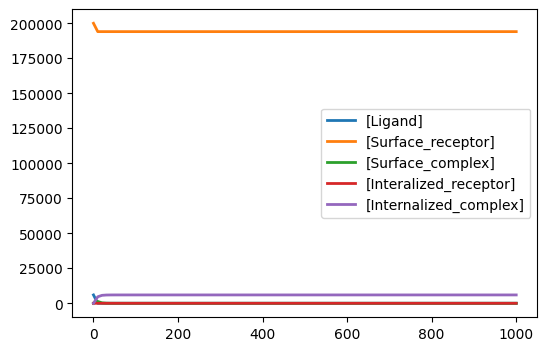

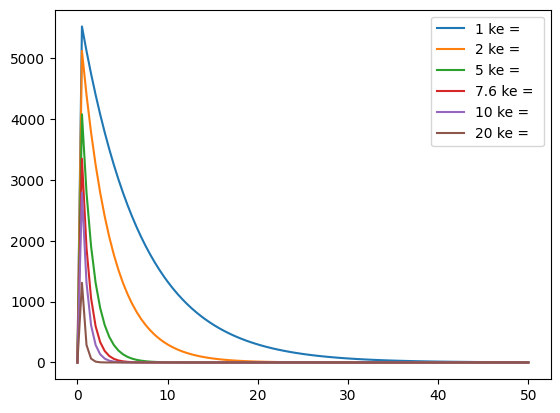

6


In [43]:
# seperate ligand and receptor entire EGFR model
shankaran_model_EGFR = te.loada("""
Ligand + Surface_receptor -> Surface_complex; Ligand*Surface_receptor*kon
Surface_complex -> Ligand + Surface_receptor; Surface_complex*koff

Interalized_receptor -> Surface_receptor; Interalized_receptor*Vr
Surface_receptor -> Interalized_receptor; Surface_receptor*kt

Surface_complex -> Internalized_complex; Surface_complex*ke

Ligand  = 0.01*Kd + 5961
Surface_receptor = Rt
Surface_complex = 0

kon = 0.097
koff = 0.24
Kd = koff/kon

kt = 0.02
ke = 0.15
Vr = kt*Rt 

Rt = 200000
V = 0.0000000004
""")
shankaran_model_EGFR.reset()
m = shankaran_model_EGFR.simulate(0, 1000, 100)
shankaran_model_EGFR.plot()

# change a species value to recreate the graph
shankaran_model_EGFR.resetAll()
count = 0
for i in [1,2,5,7.6,10,20]: 
    shankaran_model_EGFR.resetToOrigin()
    shankaran_model_EGFR.ke = 0.15*i
    result = shankaran_model_EGFR.simulate(0, 50, 100,['time','Surface_complex'])
    plt.plot(result[:,0],result[:,1], label = '%s ke = '%i) 
    count += 1

plt.legend()
plt.show()
print(count)

Manipulating the EGFR model 

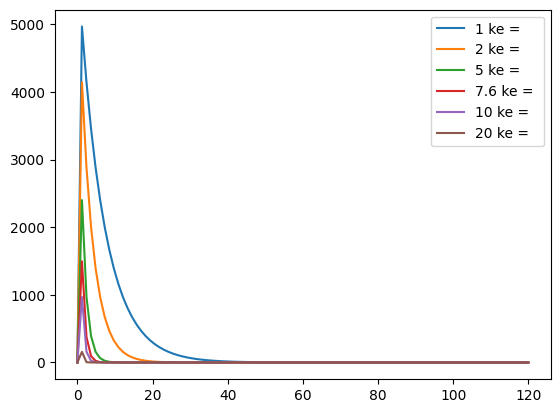

6


In [44]:
shankaran_model_EGFR.resetAll()
count = 0
for i in [1,2,5,7.6,10,20]: 
    shankaran_model_EGFR.resetToOrigin()
    shankaran_model_EGFR.ke = 0.15*i
    result = shankaran_model_EGFR.simulate(0, 120, 100,['time','Surface_complex'])
    plt.plot(result[:,0],result[:,1], label = '%s ke = '%i) 
    count += 1

plt.legend()
plt.show()
print(count)

The GPCR Model

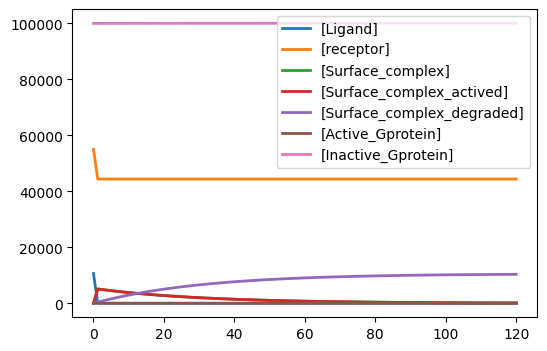

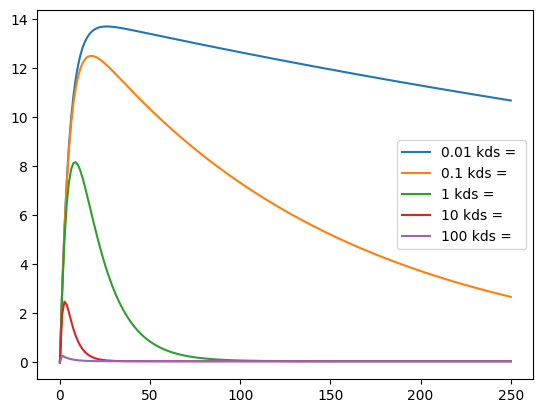

In [45]:
# seperate ligand and receptor GPCR
shankaran_model_GPCR = te.loada(""" 
Ligand + receptor -> Surface_complex; Ligand*receptor*kon
Surface_complex -> Ligand + receptor; Surface_complex*koff

Surface_complex -> Surface_complex_actived; Surface_complex*kfr
Surface_complex_actived -> Surface_complex; Surface_complex_actived*krr

Surface_complex_actived -> Surface_complex_degraded; Surface_complex_actived*kds

Surface_complex_actived -> Active_Gprotein; (Surface_complex_actived^2)*ka

Active_Gprotein -> Inactive_Gprotein; Active_Gprotein*ki
Inactive_Gprotein -> Active_Gprotein; Inactive_Gprotein*ka

Ligand = 0.01*Kd + 10612 
receptor = RT
Surface_complex = 0
Active_Gprotein = 0
Inactive_Gprotein = 100000

kon = 84000000
koff = 0.37
Kd = koff/kon
kfr = 10
krr = 10
kds = 0.065
ka = 0.0000001
ki = 0.2

V = 0.0000000004
RT = 55000 
GT = 100000
""")
shankaran_model_GPCR.resetToOrigin()
GPCR_model = shankaran_model_GPCR.simulate(0,120,100)
shankaran_model_GPCR.plot()

shankaran_model_GPCR.resetAll()
for i in [10**-2, 10**-1, 10**0, 10**1, 10**2]:
    shankaran_model_GPCR.resetToOrigin()
    shankaran_model_GPCR.kds = 0.065*i
    result = shankaran_model_GPCR.simulate(0, 250, 200,['time','Active_Gprotein'])
    plt.plot(result[:,0],result[:,1], label = '%s kds = ' %i)

plt.legend()
plt.show()

Manipulate the model and reproduce the graphs for the GPCR

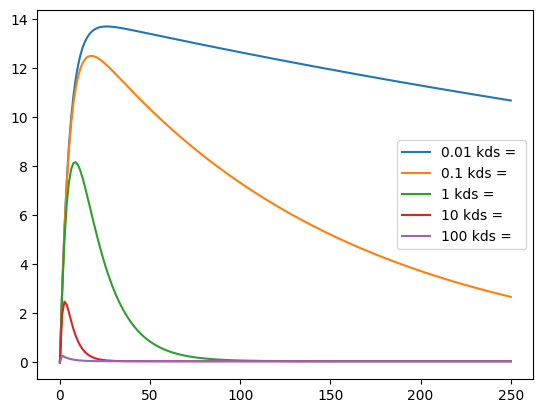

In [46]:
shankaran_model_GPCR.resetAll()
for i in [10**-2, 10**-1, 10**0, 10**1, 10**2]:
    shankaran_model_GPCR.resetToOrigin()
    shankaran_model_GPCR.kds = 0.065*i
    result = shankaran_model_GPCR.simulate(0, 250, 200,['time','Active_Gprotein'])
    plt.plot(result[:,0],result[:,1], label = '%s kds = ' %i)

plt.legend()
plt.show()